# Check Zarr File

In [4]:
import os

In [5]:
os.environ

environ{'SHELL': '/bin/bash',
        'CONDA_MKL_INTERFACE_LAYER_BACKUP': '',
        'CONDA_EXE': '/home/jhrag/anaconda3/bin/conda',
        '_CE_M': '',
        'AZURE_CONSTR_dasdata': 'DefaultEndpointsProtocol=https;AccountName=dasdata;AccountKey=X3Hx05zkPXvESvGzbS2fN2eIJt6/iclGM11BJK1S6CZ4XfIMX25>',
        'AZURE_KEY_lfhydrophone': 'UohL6H3jDaDLliug0g2Lg5qZZNKWdyxkq2S5KYLE0EFwLjo09auQp48PyhBRKJtYsfjXMmie/d/9+AStLFAniQ==',
        'PWD': '/home/jhrag',
        'LOGNAME': 'jhrag',
        'XDG_SESSION_TYPE': 'tty',
        'CONDA_PREFIX': '/home/jhrag/anaconda3/envs/ooi_dev',
        '_': '/home/jhrag/anaconda3/envs/ooi_dev/bin/jupyter',
        'AZURE_CONSTR_ooidata': 'DefaultEndpointsProtocol=https;AccountName=ooidata;AccountKey=ibLlKtCIS3BRkG2XveLGlTgs4dElF0PAs7HFKaZ5LhVuQiJgEhLC9uDLmz7QACPMr2qleg6QQTq8+AStSKqsqg==;EndpointSuffix=core.windows.net',
        'MOTD_SHOWN': 'pam',
        'HOME': '/home/jhrag',
        'LANG': 'C.UTF-8',
        'LS_COLORS': 'rs=0:di=01;34:ln=01;36:m

In [7]:
connection_string = os.environ['AZURE_CONSTR_ooidata']
account_name = 'ooidata'

storage_options = {'account_name':account_name, 'connection_string':connection_string}
ds = xr.open_zarr('abfs://lfhydrophonezarr/ooi_lfhydrophones.zarr', storage_options=storage_options)

In [1]:
import xarray as xr

In [2]:
fn = '/datadrive/lfhydrophone/ooi_lfhydrophones.zarr/'
ds = xr.open_zarr(fn)

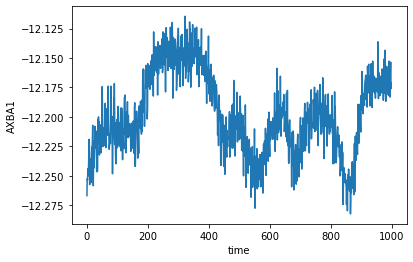

In [3]:
ds['AXBA1'][-1000:].plot()

# Debug mseed2zarr 3/20/23

In [1]:
'''
mseed2zarr.py - this converts the mseed files saved in lfhydrophone/mseed2 to a zarr store

mseed files are not uniformly created, because I was simultaneously developing the code while downloading the files
This results in alot of strange handling of the timestamps around 2016

03.06.2023 - updating LF hydrophone zarr store to contain data through 2022. I'm thinking that I'm
    going to create the zarr store from scratch again and that I will still not have the ability 
    to append. I'm creating it from scratch so that I can add calibration information
'''
import obspy
import os
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import io
from tqdm import tqdm
import xarray as xr
from dask.distributed import Client

connect_str = os.environ['AZURE_CONSTR_ooidata']
# Create the BlobServiceClient object which will be used to create a container client
blob_service_client = BlobServiceClient.from_connection_string(connect_str)
# Create a unique name for the container
container_name = 'lfhydrophonemseed'

# Create container
container_client = blob_service_client.get_container_client(container_name)

station_names = ['AXBA1','AXCC1','AXEC2','HYSB1', 'HYS14']
calib_vals = [2257.53, 2480.98, 2421.9, 2311.11, 2499.09] # counts/PA
calib = dict(zip(station_names, calib_vals))

zarr_dir = '/datadrive/lfhydrophone/ooi_lfhydrophones.zarr'

# List the blobs in the container
blob_list = list(container_client.list_blobs())
last_int_idx = -1

start_idx = 0
dry_run = False

In [8]:
blob_list[15].name

'2015_01_16.miniseed'

In [9]:
single_blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_list[15].name)

In [13]:
single_blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_list[16].name)
with open(file='temp.miniseed', mode="wb") as sample_blob:
    download_stream = single_blob_client.download_blob()
    sample_blob.write(download_stream.readall())

In [7]:
blob_service_client